In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lcs import *
import arviz as az

In [4]:
with open("Data/infer_contagion_functions.json") as file:
    data = json.load(file)

A = np.array(data["A"], dtype=float)
c1 = np.array(data["c1"], dtype=float)
c2 = np.array(data["c2"], dtype=float)
x1 = np.array(data["x1"], dtype=int)
x2 = np.array(data["x2"], dtype=int)
A1_samples = np.array(data["A1-samples"], dtype=int)
A2_samples = np.array(data["A2-samples"], dtype=int)
gamma1_samples = np.array(data["gamma1-samples"], dtype=float)
gamma2_samples = np.array(data["gamma2-samples"], dtype=float)
c1_samples = np.array(data["c1-samples"], dtype=float)
c2_samples = np.array(data["c2-samples"], dtype=float)
l1 = np.array(data["l1"], dtype=float)
l2 = np.array(data["l2"], dtype=float)

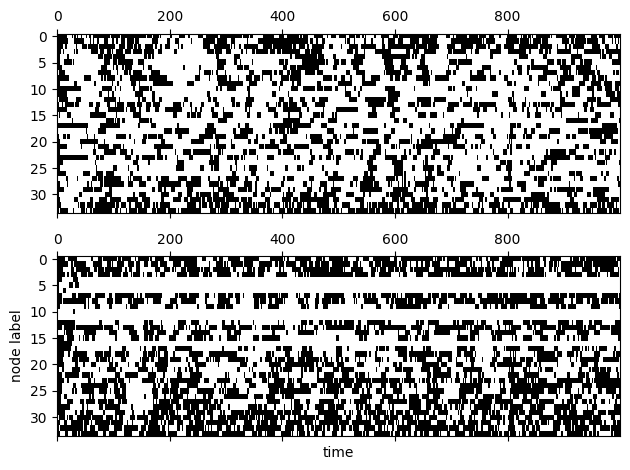

In [4]:
plt.figure()
plt.subplot(211)
plt.spy(x1.T, aspect="auto")

plt.subplot(212)
plt.spy(x2.T, aspect="auto")
plt.xlabel("time")
plt.ylabel("node label")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Log posterior probability", color=color)
ax1.plot(l1, color=color, label="Simple contagion")
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel(
    "Log posterior probability", color=color
)  # we already handled the x-label with ax1
ax2.plot(l2, color=color, label="Threshold contagion")
ax2.tick_params(axis="y", labelcolor=color)

fig.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
import cmasher as cmr

cmap = cmr.gem
p1 = np.mean(A1_samples, axis=0)
p2 = np.mean(A2_samples, axis=0)
plt.subplot(131)
plt.title("Simple contagion")
plt.imshow(p1, cmap=cmap, vmin=0, vmax=1)

plt.subplot(132)
plt.title("Threshold contagion")
plt.imshow(p2, cmap=cmap, vmin=0, vmax=1)

plt.subplot(133)
plt.title("ZKC")
plt.imshow(A, cmap=cmap, vmin=0, vmax=1)
plt.tight_layout()
plt.savefig("test.png", dpi=1000)

In [ ]:
# import cmasher as cmr
# cmap = cmr.ember
colors = ["steelblue", "darksalmon", "mediumseagreen"]

kmax = np.max(degrees(A))
n = A.shape[0]

nus = np.arange(0, n, 1)

plt.figure()
plt.subplot(211)

# simple contagion
plt.scatter(nus, c1, color=colors[0], label="Simple contagion")

v = plt.violinplot(c1_samples, positions=nus, showextrema=False)
for vp in v["bodies"]:
    vp.set_facecolor(colors[0])
    vp.set_alpha(0.5)

plt.plot(c1_samples.mean(axis=0), linewidth=0.5, color=colors[0])

# threshold contagion, tau=2
plt.scatter(nus, c2, color=colors[1], label="Threshold contagion")

v = plt.violinplot(c2_samples, positions=nus, showextrema=False)
for vp in v["bodies"]:
    vp.set_facecolor(colors[1])
    vp.set_alpha(0.5)

plt.plot(c2_samples.mean(axis=0), linewidth=0.5, color=colors[1])

plt.xticks(np.arange(0, n, 5))
plt.xlabel(r"$\nu$")
plt.ylabel(r"$c(\nu)$")


plt.xlim([0, kmax + 2.5])
plt.ylim([0, 1])

plt.legend()

plt.subplot(212)

# simple contagion
kmax_samples = [np.max(degrees(A1_samples[i])) for i in range(A1_samples.shape[0])]
plt.plot([kmax, kmax], [0, 1], "k--")
plt.hist(kmax_samples, bins=nus, density=True, color=colors[0])

# threshold contagion
kmax_samples = [np.max(degrees(A2_samples[i])) for i in range(A2_samples.shape[1])]
plt.plot([kmax, kmax], [0, 1], "k--")
plt.hist(kmax_samples, bins=nus, density=True, color=colors[1])
plt.xticks(np.arange(0, n, 5))

# ground truth event distribution
nl, ml = count_all_infection_events(x1, A)
p1_nu = nl.sum(axis=0) + ml.sum(axis=0)
p1_nu = p1_nu / np.sum(p1_nu)
plt.bar(nus, p1_nu, color=colors[0], alpha=0.5)

nl, ml = count_all_infection_events(x2, A)
p2_nu = nl.sum(axis=0) + ml.sum(axis=0)
p2_nu = p2_nu / np.sum(p2_nu)
plt.bar(nus, p2_nu, color=colors[1], alpha=0.5)

plt.xlim([0, kmax + 2.5])
plt.ylim([0, 1])
plt.xlabel(r"$\nu$")
plt.ylabel(r"$Pr$")

sns.despine()
plt.tight_layout()

plt.savefig("Figures/contagion_inference.png", dpi=1000)
plt.savefig("Figures/contagion_inference.pdf", dpi=1000)
plt.show()

# kde and then find the hdpi

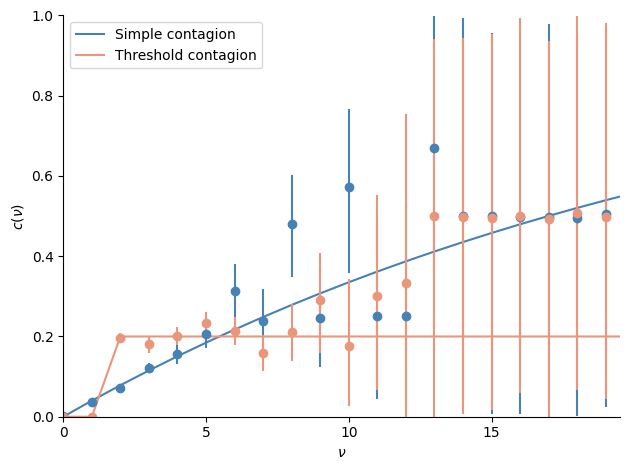

In [7]:
# import cmasher as cmr
# cmap = cmr.ember
colors = ["steelblue", "darksalmon", "mediumseagreen"]

kmax = np.max(degrees(A))
n = A.shape[0]

nus = np.arange(0, n, 1)

plt.figure()

# simple contagion
c1_mean = c1_samples.mean(axis=0)
plt.plot(nus, c1, "-", color=colors[0], label="Simple contagion")
# plt.scatter(nus, c1_mean, linewidth=0.5, color=colors[0])

err_c1 = np.zeros((2, n))
c1_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c1_samples[:, i], hdi_prob=0.95)
    x, y = interval
    err_c1[0, i] = max(c1_mean[i] - x, 0)
    err_c1[1, i] = max(y - c1_mean[i], 0)
plt.errorbar(nus, c1_mean, err_c1, color=colors[0], fmt="o")

# threshold contagion, tau=2
c2_mean = c2_samples.mean(axis=0)
plt.plot(nus, c2, "-", color=colors[1], label="Threshold contagion")
# plt.scatter(nus, c2_mean, linewidth=0.5, color=colors[1])

err_c2 = np.zeros((2, n))
c2_mode = np.zeros(n)
for i in range(n):
    interval = az.hdi(c2_samples[:, i], alpha=0.05, roundto=4)
    x, y = interval
    err_c2[0, i] = max(c2_mean[i] - x, 0)
    err_c2[1, i] = max(y - c2_mean[i], 0)
plt.errorbar(nus, c2_mean, err_c2, color=colors[1], fmt="o")

plt.xticks(np.arange(0, n, 5))
plt.xlabel(r"$\nu$")
plt.ylabel(r"$c(\nu)$")


plt.xlim([0, kmax + 2.5])
plt.ylim([0, 1])

plt.legend(loc="upper left")

sns.despine()
plt.tight_layout()

plt.savefig("Figures/contagion_inference.png", dpi=1000)
plt.savefig("Figures/contagion_inference.pdf", dpi=1000)
plt.show()